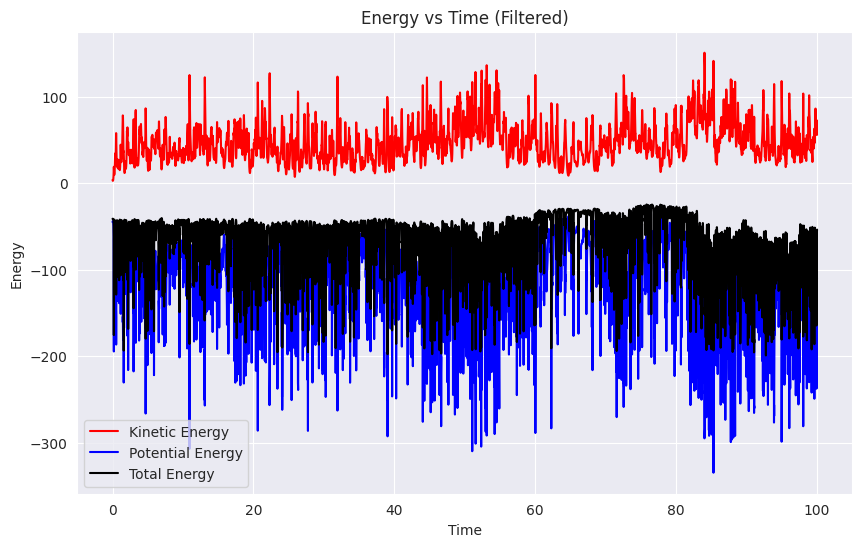

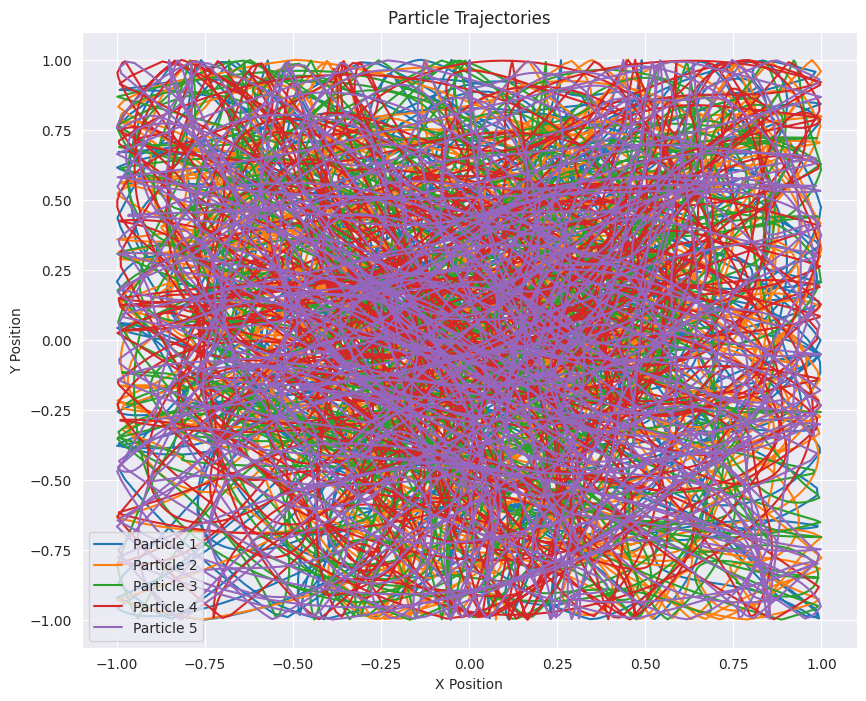

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import utils as ut
import importlib

importlib.reload(ut)

seed_value = 42

N = 5  # Number of particles
tEnd = 100.0  # time at which simulation ends
dt = 0.01  # timestep
softening = 0.15  # softening length
G = 1.0  # Newton's Gravitational Constant
boxSize = 1.0
mass_coef = 10.0
dims = 2

hparams = {
    'N': N,  # Number of particles
    'tEnd': tEnd,  # Time at which simulation ends
    'dt': dt,  # Timestep
    'G': G,  # Newton's Gravitational Constant
    'boxSize': boxSize,  # Size of the simulation box
    'mass_coef': mass_coef  # Mass coefficient
}

combined_data = ut.simulate_gravitational_system(seed_value, N, tEnd, dt, softening, G, boxSize, mass_coef, dims=dims, init_boxsize=1)


In [2]:
# %matplotlib qt
# ut.interactive_trajectory_plot_just_sim(combined_data, particle_index=None, boxSize=boxSize, dims=dims)
# %matplotlib inline

combined_data shape: (9755, 5, 4)
inputs_np shape: (9754, 5, 4)
targets_np shape: (9754, 5, 4)


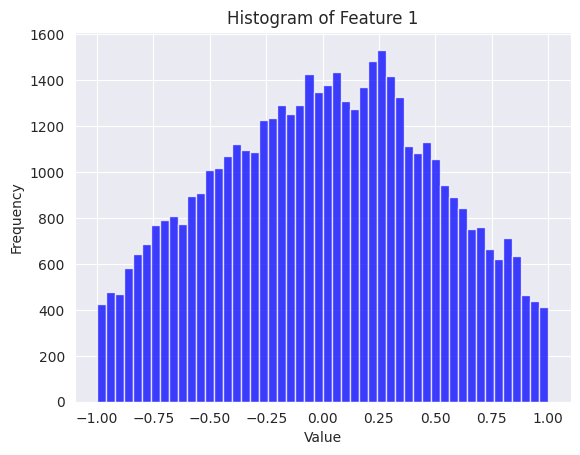

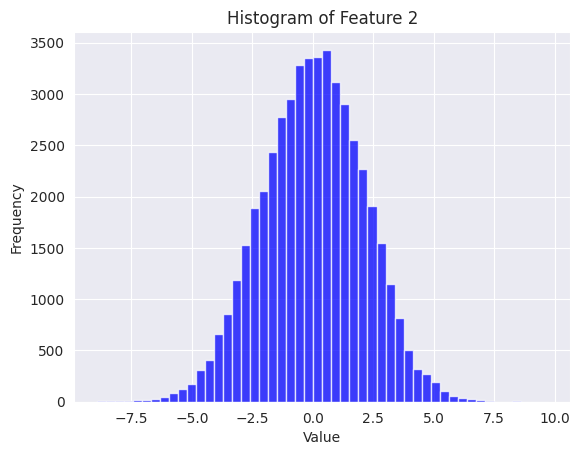

Normalized:


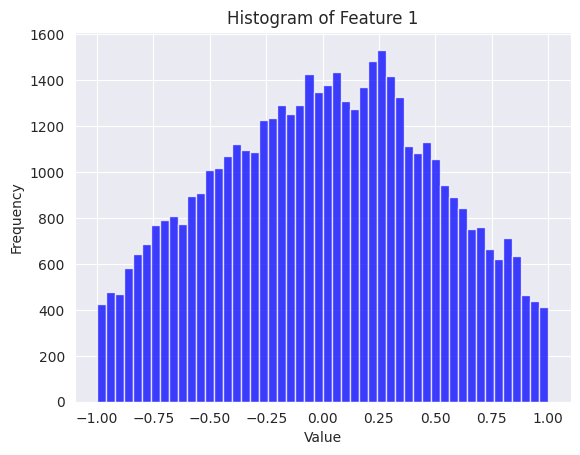

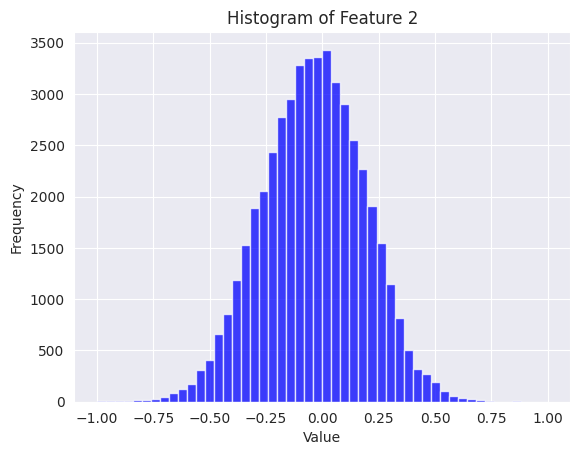

In [3]:
inputs_np, targets_np = ut.process_data(combined_data, dims=dims)

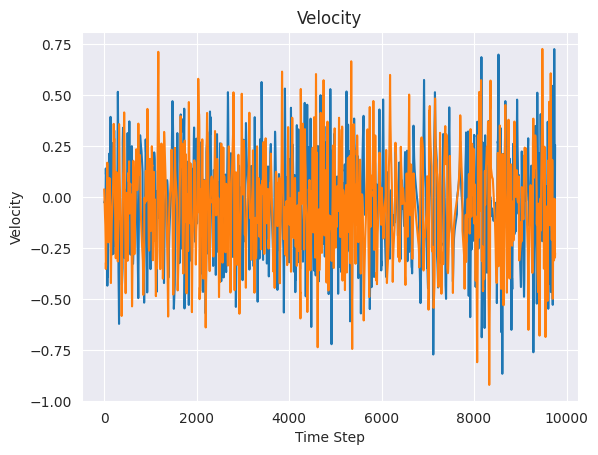

In [4]:
#time_steps = np.arange(mse_values.shape[0])  # Generate an array of time steps
plt.figure()
plt.plot(inputs_np[:, 0, 2:])  # Plot MSE values against time steps

plt.xlabel('Time Step')
plt.ylabel('Velocity')
plt.title('Velocity')
plt.show()

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
from datetime import datetime
import models

torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)


activation = 'relu'
mlp_activation = nn.Tanh
particle_dim = 2 * dims  # 3 for position and 3 for velocity
model_dim = 256
num_heads = 4
num_layers = 1
hidden_dims = [256, 256, 256]
lr = 0.001
batch_size = 32
particle_index = 0
precision = 'double'
mlp_type = 'output'
model_dict = {
    'particle_dim': particle_dim,  # 3 for position and 3 for velocity
    'model_dim': model_dim,
    'num_heads': num_heads,
    'num_layers': num_layers,
    'hidden_dims': str(hidden_dims),
    'lr': lr,
    'batch_size': batch_size,
    'activation': activation,
    'precision': precision,
    'mlp_type': mlp_type,
}
hparams.update(model_dict)

#experiment
current_time = datetime.now().strftime('%Y-%m-%d %H:%M')
experiment_folder = f'runs_g_1p_encoder_mlp/{activation}_{current_time}_l1_{str(model_dim)}_{str(num_heads)}_{str(num_layers)}_{str(batch_size)}_{str(lr)}_double_{dims}_{str(hidden_dims).replace("[", "(").replace("]", ")")}_{str(mlp_activation.__name__)}_mlp{mlp_type}'
writer = SummaryWriter(experiment_folder)

np.savez(os.path.join(experiment_folder, 'data_arrays.npz'), inputs=inputs_np, targets=targets_np)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = models.EncoderWithMLP(particle_dim=particle_dim,
                              model_dim=model_dim,
                              num_heads=num_heads,
                              num_layers=num_layers,
                              particle_index=particle_index,
                              activation=activation,
                              hidden_dims=hidden_dims,
                              mlp_act=nn.ReLU,
                              mlp_type=mlp_type,
                              hparams=hparams                              
                              ).to(device)

inputs_tensor = torch.tensor(inputs_np, dtype=torch.float64)
targets_tensor = torch.tensor(targets_np, dtype=torch.float64)
dataset = TensorDataset(inputs_tensor.to(device).double(), targets_tensor[:, particle_index, :].to(device).double())
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_epochs = 600
epoch = 0

cuda


In [6]:
import importlib
importlib.reload(ut)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epoch, loss = ut.train_model(model, optimizer, criterion, data_loader, num_epochs, old_epoch=epoch, writer=writer,
                             dims=dims)

Epoch [2/600], avg_both: 0.04757, avg_pos:  0.05093, avg_vel:  0.04420, perc_pos:  15.80399%, perc_vel:  37.14777%
Epoch [3/600], avg_both: 0.02661, avg_pos:  0.02522, avg_vel:  0.02801, perc_pos:  7.81091%, perc_vel:  23.58646%
Epoch [4/600], avg_both: 0.02315, avg_pos:  0.02073, avg_vel:  0.02557, perc_pos:  6.50991%, perc_vel:  21.45969%
Epoch [5/600], avg_both: 0.02287, avg_pos:  0.02092, avg_vel:  0.02483, perc_pos:  6.56560%, perc_vel:  20.69807%
Epoch [6/600], avg_both: 0.02228, avg_pos:  0.01971, avg_vel:  0.02484, perc_pos:  6.21885%, perc_vel:  20.92969%
Epoch [7/600], avg_both: 0.02181, avg_pos:  0.01962, avg_vel:  0.02399, perc_pos:  6.24885%, perc_vel:  19.75030%
Epoch [8/600], avg_both: 0.02143, avg_pos:  0.01921, avg_vel:  0.02365, perc_pos:  6.19480%, perc_vel:  19.42799%
Epoch [9/600], avg_both: 0.02018, avg_pos:  0.01718, avg_vel:  0.02319, perc_pos:  5.42005%, perc_vel:  19.04015%
Epoch [10/600], avg_both: 0.02019, avg_pos:  0.01763, avg_vel:  0.02275, perc_pos:  5.5

In [7]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr * 0.01)
data_loader = DataLoader(dataset, batch_size=int(batch_size), shuffle=True)
epoch, loss = ut.train_model(model, optimizer, criterion, data_loader, num_epochs, old_epoch=epoch, writer=writer,
                             dims=dims)

Epoch [512/600], avg_both: 0.00596, avg_pos:  0.00253, avg_vel:  0.00938, perc_pos:  0.87222%, perc_vel:  7.70102%
Epoch [513/600], avg_both: 0.00552, avg_pos:  0.00221, avg_vel:  0.00882, perc_pos:  0.75650%, perc_vel:  7.25552%
Epoch [514/600], avg_both: 0.00539, avg_pos:  0.00213, avg_vel:  0.00865, perc_pos:  0.73386%, perc_vel:  7.08833%
Epoch [515/600], avg_both: 0.00529, avg_pos:  0.00208, avg_vel:  0.00850, perc_pos:  0.71563%, perc_vel:  7.02869%
Epoch [516/600], avg_both: 0.00520, avg_pos:  0.00203, avg_vel:  0.00837, perc_pos:  0.69651%, perc_vel:  6.89658%
Epoch [517/600], avg_both: 0.00517, avg_pos:  0.00200, avg_vel:  0.00835, perc_pos:  0.68712%, perc_vel:  6.88163%
Epoch [518/600], avg_both: 0.00513, avg_pos:  0.00199, avg_vel:  0.00828, perc_pos:  0.68669%, perc_vel:  6.82298%
Epoch [519/600], avg_both: 0.00509, avg_pos:  0.00197, avg_vel:  0.00821, perc_pos:  0.67970%, perc_vel:  6.77745%
Epoch [520/600], avg_both: 0.00508, avg_pos:  0.00196, avg_vel:  0.00819, perc_p

In [8]:
predicted_data = ut.get_predicted_data(model, dataset.tensors[0], particle_index)
import importlib

#%matplotlib qt
importlib.reload(ut)
ut.plot_trajectory(targets_np, predicted_data, particle_index=particle_index, writer=writer, epoch=epoch, dims=dims)

ut.plot_error_over_time_position(targets_np, predicted_data, particle_index, writer=writer, epoch=epoch, dims=dims)
ut.plot_error_over_time_velocity(targets_np, predicted_data, particle_index, writer=writer, epoch=epoch, dims=dims)

ut.log_hparams(writer, hparams, loss.item())